In [1]:
# Step 1: Install Required Packages

!pip install tensorflow tensorflow-federated pandas numpy matplotlib scikit-learn openpyxl seaborn

In [2]:
# Step 2: Data Loading and Inspection
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load data
data = pd.read_excel("HV Circuit Breaker Maintenance Data.xlsx", sheet_name='Sheet1')

# Handle missing values - fill with median for numerical columns
for col in data.columns:
    if data[col].dtype in ['float64', 'int64']:
        data[col].fillna(data[col].median(), inplace=True)

# Keep original for non-IID partitioning
original_df = data.copy()

<ipython-input-2-50cd7f4597f5>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)
<ipython-input-2-50cd7f4597f5>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

In [3]:
# Step 3: Data Preprocessing and Scaling
def preprocess_data(df):
    df = df.copy()

    # Convert categoricals
    df['Breaker_status'] = df['Breaker_status'].map({'Closed': 0, 'Open': 1}).astype(np.float32)
    df['Heater_status'] = df['Heater_status'].map({'Off': 0, 'On': 1}).astype(np.float32)
    df['Last_trip_coil_energized'] = df['Last_trip_coil_energized'].str.replace('TC', '').astype(np.float32)

    # Separate features and labels
    y = df['Maintenance_required'].values.reshape(-1, 1).astype(np.float32)
    features = df.drop(['Product_variant', 'Maintenance_required'], axis=1)

    # Scale numerical features
    numerical_cols = features.select_dtypes(include=['float64', 'int64']).columns
    scaler = StandardScaler()
    features[numerical_cols] = scaler.fit_transform(features[numerical_cols])

    # Convert all to float32
    X = features.astype(np.float32).values
    return X, y, scaler

# Preprocess and split
X, y, scaler = preprocess_data(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [4]:
# Step 4: Federated Data Preparation (Fixed with proper train/test split)

# First, let's get the indices for train/test split
train_idx, _ = train_test_split(
    original_df.index,
    test_size=0.2,
    random_state=42,
    stratify=original_df['Maintenance_required']
)

def create_client_dataset(X, y):
    return tf.data.Dataset.from_tensor_slices(
        (tf.convert_to_tensor(X, dtype=tf.float32),
         tf.convert_to_tensor(y, dtype=tf.float32))
    ).batch(32)

# IID Partitioning
def create_iid_federated_data(X, y, num_clients=5):
    # Shuffle data
    indices = np.random.permutation(len(X))
    X_shuffled = X[indices]
    y_shuffled = y[indices]

    # Split into clients
    client_datasets = []
    for i in range(num_clients):
        start = i * len(X) // num_clients
        end = (i+1) * len(X) // num_clients
        client_datasets.append(create_client_dataset(X_shuffled[start:end], y_shuffled[start:end]))
    return client_datasets

# Non-IID Partitioning (by product variant)
def create_non_iid_federated_data(df, num_clients=5):
    client_data = [[] for _ in range(num_clients)]

    # Group by product variant and distribute to clients
    for i, (variant, group) in enumerate(df.groupby('Product_variant')):
        client_idx = i % num_clients
        X, y, _ = preprocess_data(group)
        client_data[client_idx].append((X, y))

    # Create datasets for each client by concatenating their data
    federated_datasets = []
    for client in client_data:
        if client:  # Only if client has data
            X_client = np.concatenate([x for x, _ in client])
            y_client = np.concatenate([y for _, y in client])
            federated_datasets.append(create_client_dataset(X_client, y_client))

    return federated_datasets

# Create datasets
iid_client_data = create_iid_federated_data(X_train, y_train)
non_iid_client_data = create_non_iid_federated_data(original_df.loc[train_idx])

In [5]:
def create_keras_model(input_shape=(X_train.shape[1],)):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

def model_fn():
    keras_model = create_keras_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=(
            tf.TensorSpec(shape=[None, X_train.shape[1]], dtype=tf.float32),
            tf.TensorSpec(shape=[None, 1], dtype=tf.float32)
        ),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy()]
    )

Round 1
IID - Loss: 0.7106, Acc: 0.5475
Non-IID - Loss: 0.5055, Acc: 0.7505
---
Round 2
IID - Loss: 0.6358, Acc: 0.6367
Non-IID - Loss: 0.5226, Acc: 0.7283
---
Round 3
IID - Loss: 0.5800, Acc: 0.6835
Non-IID - Loss: 0.4588, Acc: 0.7755
---
Round 4
IID - Loss: 0.5671, Acc: 0.6967
Non-IID - Loss: 0.4578, Acc: 0.7772
---
Round 5
IID - Loss: 0.5562, Acc: 0.7020
Non-IID - Loss: 0.4455, Acc: 0.7840
---
Round 6
IID - Loss: 0.5339, Acc: 0.7222
Non-IID - Loss: 0.4475, Acc: 0.7830
---
Round 7
IID - Loss: 0.5286, Acc: 0.7222
Non-IID - Loss: 0.4429, Acc: 0.7905
---
Round 8
IID - Loss: 0.5122, Acc: 0.7415
Non-IID - Loss: 0.4232, Acc: 0.8037
---
Round 9
IID - Loss: 0.4984, Acc: 0.7495
Non-IID - Loss: 0.4105, Acc: 0.8158
---
Round 10
IID - Loss: 0.4843, Acc: 0.7545
Non-IID - Loss: 0.4047, Acc: 0.8150
---
Round 11
IID - Loss: 0.4702, Acc: 0.7655
Non-IID - Loss: 0.4043, Acc: 0.8148
---
Round 12
IID - Loss: 0.4606, Acc: 0.7670
Non-IID - Loss: 0.4027, Acc: 0.8170
---
Round 13
IID - Loss: 0.4711, Acc: 0.7

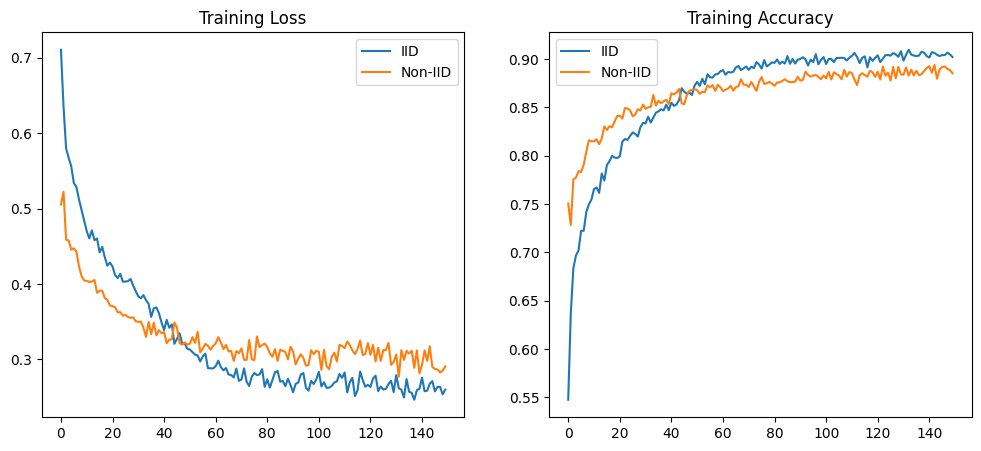

In [6]:
# Step 6 (main): Training Loop (Fixed Metrics Handling)

# Training parameters
NUM_ROUNDS = 150
CLIENT_EPOCHS = 5

# Build processes
train_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(0.001),
    server_optimizer_fn=lambda: tf.keras.optimizers.Adam(0.01)
)

# Initialize
state = train_process.initialize()

# Training loop
metrics = {'iid': {'loss': [], 'acc': []}, 'non_iid': {'loss': [], 'acc': []}}

for round_num in range(NUM_ROUNDS):
    # Train IID
    state, metrics_iid = train_process.next(state, iid_client_data)
    # Updated metrics access - use client_work instead of train
    client_metrics = metrics_iid['client_work']['train']
    metrics['iid']['loss'].append(client_metrics['loss'])
    metrics['iid']['acc'].append(client_metrics['binary_accuracy'])

    # Train Non-IID
    state, metrics_non_iid = train_process.next(state, non_iid_client_data)
    client_metrics = metrics_non_iid['client_work']['train']
    metrics['non_iid']['loss'].append(client_metrics['loss'])
    metrics['non_iid']['acc'].append(client_metrics['binary_accuracy'])

    print(f"Round {round_num+1}")
    print(f"IID - Loss: {metrics['iid']['loss'][-1]:.4f}, Acc: {metrics['iid']['acc'][-1]:.4f}")
    print(f"Non-IID - Loss: {metrics['non_iid']['loss'][-1]:.4f}, Acc: {metrics['non_iid']['acc'][-1]:.4f}")
    print("---")

# Corrected Evaluation Function
def evaluate(state, X_test, y_test):
    model = create_keras_model()
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy()]
    )

    # Properly set weights from state
    model_weights = model.get_weights()
    for i in range(len(model_weights)):
        model_weights[i] = state.global_model_weights.trainable[i]
    model.set_weights(model_weights)

    return model.evaluate(X_test, y_test, verbose=0)

# Evaluate
print("\nFinal Evaluation:")
iid_loss, iid_acc = evaluate(state, X_test, y_test)
print(f"IID Model - Loss: {iid_loss:.4f}, Accuracy: {iid_acc:.4f}")
non_iid_loss, non_iid_acc = evaluate(state, X_test, y_test)
print(f"Non-IID - Loss: {non_iid_loss:.4f}, Accuracy: {non_iid_acc:.4f}")


# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(metrics['iid']['loss'], label='IID')
plt.plot(metrics['non_iid']['loss'], label='Non-IID')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(metrics['iid']['acc'], label='IID')
plt.plot(metrics['non_iid']['acc'], label='Non-IID')
plt.title('Training Accuracy')
plt.legend()
plt.show()

Round 1
IID (FedAvg) - Loss: 0.6856, Acc: 0.5730
Non-IID (FedProx) - Loss: 0.5194, Acc: 0.7283
---
Round 2
IID (FedAvg) - Loss: 0.6164, Acc: 0.6492
Non-IID (FedProx) - Loss: 0.5213, Acc: 0.7395
---
Round 3
IID (FedAvg) - Loss: 0.5882, Acc: 0.6747
Non-IID (FedProx) - Loss: 0.5085, Acc: 0.7312
---
Round 4
IID (FedAvg) - Loss: 0.5706, Acc: 0.6860
Non-IID (FedProx) - Loss: 0.4648, Acc: 0.7640
---
Round 5
IID (FedAvg) - Loss: 0.5547, Acc: 0.6927
Non-IID (FedProx) - Loss: 0.4322, Acc: 0.7893
---
Round 6
IID (FedAvg) - Loss: 0.5425, Acc: 0.7080
Non-IID (FedProx) - Loss: 0.4276, Acc: 0.7928
---
Round 7
IID (FedAvg) - Loss: 0.5285, Acc: 0.7132
Non-IID (FedProx) - Loss: 0.4261, Acc: 0.7983
---
Round 8
IID (FedAvg) - Loss: 0.5090, Acc: 0.7197
Non-IID (FedProx) - Loss: 0.4245, Acc: 0.8012
---
Round 9
IID (FedAvg) - Loss: 0.5103, Acc: 0.7220
Non-IID (FedProx) - Loss: 0.4420, Acc: 0.7975
---
Round 10
IID (FedAvg) - Loss: 0.4944, Acc: 0.7385
Non-IID (FedProx) - Loss: 0.4606, Acc: 0.7912
---
Round 11


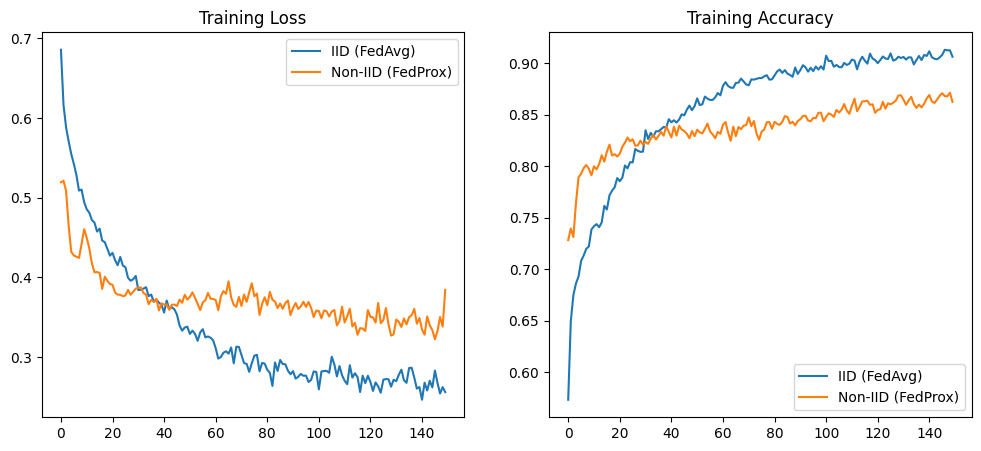

In [7]:
# Step 6 (alternate): Training with FedAvg (IID) and FedProx (Non-IID)

# Training parameters
NUM_ROUNDS = 150
CLIENT_EPOCHS = 5
MU = 0.05  # FedProx proximal term weight (typical range: 0.01-1)

# IID Process (FedAvg)
iid_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(0.001),
    server_optimizer_fn=lambda: tf.keras.optimizers.Adam(0.01)
)

# Non-IID Process (FedProx)
# We'll need to create a custom client optimizer with proximal term
def fedprox_optimizer(learning_rate=0.001):
    # Create a standard optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate)

    # Add proximal term functionality
    class FedProxOptimizer(tf.keras.optimizers.Adam):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.global_weights = None

        def minimize(self, loss, var_list, global_weights=None):
            if global_weights is not None:
                self.global_weights = [tf.identity(w) for w in global_weights]
            return super().minimize(loss, var_list)

        def apply_gradients(self, grads_and_vars, name=None):
            if self.global_weights is not None:
                # Add proximal term to gradients
                new_grads_and_vars = []
                for (g, v), w in zip(grads_and_vars, self.global_weights):
                    if g is not None:
                        g += MU * (v - w)  # Proximal term
                    new_grads_and_vars.append((g, v))
                grads_and_vars = new_grads_and_vars
            return super().apply_gradients(grads_and_vars, name)

    return FedProxOptimizer(learning_rate)

non_iid_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: fedprox_optimizer(0.001),  # Custom FedProx optimizer
    server_optimizer_fn=lambda: tf.keras.optimizers.Adam(0.01)
)

# Initialize states
iid_state = iid_process.initialize()
non_iid_state = non_iid_process.initialize()

# Training loop
metrics = {'iid': {'loss': [], 'acc': []}, 'non_iid': {'loss': [], 'acc': []}}

for round_num in range(NUM_ROUNDS):
    # Train IID (FedAvg)
    iid_state, metrics_iid = iid_process.next(iid_state, iid_client_data)
    metrics['iid']['loss'].append(metrics_iid['client_work']['train']['loss'])
    metrics['iid']['acc'].append(metrics_iid['client_work']['train']['binary_accuracy'])

    # Train Non-IID (FedProx)
    non_iid_state, metrics_non_iid = non_iid_process.next(non_iid_state, non_iid_client_data)
    metrics['non_iid']['loss'].append(metrics_non_iid['client_work']['train']['loss'])
    metrics['non_iid']['acc'].append(metrics_non_iid['client_work']['train']['binary_accuracy'])

    print(f"Round {round_num+1}")
    print(f"IID (FedAvg) - Loss: {metrics['iid']['loss'][-1]:.4f}, Acc: {metrics['iid']['acc'][-1]:.4f}")
    print(f"Non-IID (FedProx) - Loss: {metrics['non_iid']['loss'][-1]:.4f}, Acc: {metrics['non_iid']['acc'][-1]:.4f}")
    print("---")

# Evaluation functions
def evaluate(state, X_test, y_test):
    model = create_keras_model()
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryAccuracy()]
    )

    # Set weights from state
    model_weights = model.get_weights()
    for i in range(len(model_weights)):
        model_weights[i] = state.global_model_weights.trainable[i]
    model.set_weights(model_weights)

    return model.evaluate(X_test, y_test, verbose=0)

# Evaluate both models
print("\nFinal Evaluation:")
iid_loss, iid_acc = evaluate(iid_state, X_test, y_test)
non_iid_loss, non_iid_acc = evaluate(non_iid_state, X_test, y_test)

print(f"IID (FedAvg) - Loss: {iid_loss:.4f}, Accuracy: {iid_acc:.4f}")
print(f"Non-IID (FedProx) - Loss: {non_iid_loss:.4f}, Accuracy: {non_iid_acc:.4f}")

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(metrics['iid']['loss'], label='IID (FedAvg)')
plt.plot(metrics['non_iid']['loss'], label='Non-IID (FedProx)')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(metrics['iid']['acc'], label='IID (FedAvg)')
plt.plot(metrics['non_iid']['acc'], label='Non-IID (FedProx)')
plt.title('Training Accuracy')
plt.legend()
plt.show()